In [22]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle, resample
from sklearn.datasets import fetch_california_housing
#from keras.datasets import boston_housing
from sklearn.datasets import fetch_openml
from pandas import read_csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [23]:
class Node:
    """
    Base class for nodes in the network.

    Arguments:

        `inbound_nodes`: A list of nodes with edges into this node.
    """
    def __init__(self, inbound_nodes=[]):
        """
        Node's constructor (runs when the object is instantiated). Sets
        properties that all nodes need.
        """
        # A list of nodes with edges into this node.
        self.inbound_nodes = inbound_nodes
        # The eventual value of this node. Set by running
        # the forward() method.
        self.value = None
        # A list of nodes that this node outputs to.
        self.outbound_nodes = []
        # New property! Keys are the inputs to this node and
        # their values are the partials of this node with
        # respect to that input.
        self.gradients = {}
        # Sets this node as an outbound node for all of
        # this node's inputs.
        for node in inbound_nodes:
            node.outbound_nodes.append(self)

    def forward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `forward` method.
        """
        raise NotImplementedError

    def backward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `backward` method.
        """
        raise NotImplementedError


class Input(Node):
    """
    A generic input into the network.
    """
    def __init__(self):
        # The base class constructor has to run to set all
        # the properties here.
        #
        # The most important property on an Input is value.
        # self.value is set during `topological_sort` later.
        Node.__init__(self)

    def forward(self):
        # Do nothing because nothing is calculated.
        pass

    def backward(self):
        # An Input node has no inputs so the gradient (derivative)
        # is zero.
        # The key, `self`, is reference to this object.
        self.gradients = {self: 0}
        # Weights and bias may be inputs, so you need to sum
        # the gradient from output gradients.
        for n in self.outbound_nodes:
            self.gradients[self] += n.gradients[self]

class Linear(Node):
    """
    Represents a node that performs a linear transform.
    """
    def __init__(self, X, W, b):
        # The base class (Node) constructor. Weights and bias
        # are treated like inbound nodes.
        Node.__init__(self, [X, W, b])

    def forward(self):
        """
        Performs the math behind a linear transform.
        """
        X = self.inbound_nodes[0].value
        W = self.inbound_nodes[1].value
        b = self.inbound_nodes[2].value
        self.value = np.dot(X, W) + b

    def backward(self):
        """
        Calculates the gradient based on the output values.
        """
        # Initialize a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        # Cycle through the outputs. The gradient will change depending
        # on each output, so the gradients are summed over all outputs.
        for n in self.outbound_nodes:
            # Get the partial of the cost with respect to this node.
            grad_cost = n.gradients[self]
            # Set the partial of the loss with respect to this node's inputs.
            self.gradients[self.inbound_nodes[0]] += np.dot(grad_cost, self.inbound_nodes[1].value.T)
            # Set the partial of the loss with respect to this node's weights.
            self.gradients[self.inbound_nodes[1]] += np.dot(self.inbound_nodes[0].value.T, grad_cost)
            # Set the partial of the loss with respect to this node's bias.
            self.gradients[self.inbound_nodes[2]] += np.sum(grad_cost, axis=0, keepdims=False)


class Sigmoid(Node):
    """
    Represents a node that performs the sigmoid activation function.
    """
    def __init__(self, node):
        # The base class constructor.
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        """
        This method is separate from `forward` because it
        will be used with `backward` as well.

        `x`: A numpy array-like object.
        """
        return 1. / (1. + np.exp(-x))

    def forward(self):
        """
        Perform the sigmoid function and set the value.
        """
        input_value = self.inbound_nodes[0].value
        self.value = self._sigmoid(input_value)

    def backward(self):
        """
        Calculates the gradient using the derivative of
        the sigmoid function.
        """
        # Initialize the gradients to 0.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        # Sum the partial with respect to the input over all the outputs.
        for n in self.outbound_nodes:
            grad_cost = n.gradients[self]
            sigmoid = self.value
            self.gradients[self.inbound_nodes[0]] += sigmoid * (1 - sigmoid) * grad_cost


class MSE(Node):
    def __init__(self, y, a):
        """
        The mean squared error cost function.
        Should be used as the last node for a network.
        """
        # Call the base class' constructor.
        Node.__init__(self, [y, a])

    def forward(self):
        """
        Calculates the mean squared error.
        """
        # NOTE: We reshape these to avoid possible matrix/vector broadcast
        # errors.
        #
        # For example, if we subtract an array of shape (3,) from an array of shape
        # (3,1) we get an array of shape(3,3) as the result when we want
        # an array of shape (3,1) instead.
        #
        # Making both arrays (3,1) insures the result is (3,1) and does
        # an elementwise subtraction as expected.
        
        y = self.inbound_nodes[0].value.reshape(-1, 1)
        a = self.inbound_nodes[1].value.reshape(-1, 1)

        self.m = self.inbound_nodes[0].value.shape[0]
        # Save the computed output for backward.
        self.diff = y - a
        self.value = np.mean(self.diff**2)

    def backward(self):
        """
        Calculates the gradient of the cost.
        """
        self.gradients[self.inbound_nodes[0]] = (2 / self.m) * self.diff
        self.gradients[self.inbound_nodes[1]] = (-2 / self.m) * self.diff


def topological_sort(feed_dict):
    """
    Sort the nodes in topological order using Kahn's Algorithm.

    `feed_dict`: A dictionary where the key is a `Input` Node and the value is the respective value feed to that Node.

    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outbound_nodes:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
        for m in n.outbound_nodes:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def forward_and_backward(graph):
    """
    Performs a forward pass and a backward pass through a list of sorted Nodes.

    Arguments:

        `graph`: The result of calling `topological_sort`.
    """
    # Forward pass
    for n in graph:
        n.forward()

    # Backward pass
    # see: https://docs.python.org/2.3/whatsnew/section-slices.html
    for n in graph[::-1]:
        n.backward()


def sgd_update(trainables, learning_rate=1e-2):
    """
    Updates the value of each trainable with SGD.

    Arguments:

        `trainables`: A list of `Input` Nodes representing weights/biases.
        `learning_rate`: The learning rate.
    """
    # Performs SGD
    #
    # Loop over the trainables
    for t in trainables:
        # Change the trainable's value by subtracting the learning rate
        # multiplied by the partial of the cost with respect to this
        # trainable.
        partial = t.gradients[t]
        t.value -= learning_rate * partial

In [24]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
#target = raw_df.values[1::2, 2]

In [69]:
# Load data
#data = boston_housing.load_data()#fetch_california_housing()#load_boston()
#data = fetch_openml('mnist_784', version=1)
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = read_csv('./housing.csv', header=None, delimiter=r"\s+", names=column_names)
#data = load_boston()
#print(data)

X_ = data.values
y_ = data['MEDV'].values

#X_ = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])#= data['data']
#y_ = raw_df.values[1::2, 2]#= data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

X_begin = X_
y_begin = y_

X_, X_test, y_, y_test = train_test_split(
    X_begin, y_begin, test_size=0.8, shuffle=False
)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}
val_feed_dict = {
    X: X_test,
    y: y_test,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}
history = dict.fromkeys(['val_loss', 'loss'])

epochs = 1000
# Total number of examples
m = X_.shape[0]
batch_size = 11
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
val_graph = topological_sort(val_feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
loss_arr = []
val_loss_arr = []
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables)

        loss += graph[-1].value
        
    loss_arr.append(loss/steps_per_epoch)
    
    print("Epoch: {}, Train Loss: {:.4f}".format(i+1, loss/steps_per_epoch))
    
    for node in val_graph:
        node.forward()
    val_loss = val_graph[-1].value
    val_loss_arr.append(val_loss)
    print(f"Epoch {i+1} - Train Loss: {loss/steps_per_epoch:.4f} - Val Loss: {val_loss:.4f}")

Total number of examples = 101
Epoch: 1, Train Loss: 237.2488
Epoch 1 - Train Loss: 237.2488 - Val Loss: 134.6227
Epoch: 2, Train Loss: 48.1934
Epoch 2 - Train Loss: 48.1934 - Val Loss: 93.8700
Epoch: 3, Train Loss: 21.0880
Epoch 3 - Train Loss: 21.0880 - Val Loss: 23.2107
Epoch: 4, Train Loss: 19.2110
Epoch 4 - Train Loss: 19.2110 - Val Loss: 10.3950
Epoch: 5, Train Loss: 9.9790
Epoch 5 - Train Loss: 9.9790 - Val Loss: 4.8041
Epoch: 6, Train Loss: 12.5865
Epoch 6 - Train Loss: 12.5865 - Val Loss: 7.9237
Epoch: 7, Train Loss: 17.6066
Epoch 7 - Train Loss: 17.6066 - Val Loss: 8.1734
Epoch: 8, Train Loss: 13.6488
Epoch 8 - Train Loss: 13.6488 - Val Loss: 32.2218
Epoch: 9, Train Loss: 17.4807
Epoch 9 - Train Loss: 17.4807 - Val Loss: 17.6792
Epoch: 10, Train Loss: 18.1394
Epoch 10 - Train Loss: 18.1394 - Val Loss: 8.0916
Epoch: 11, Train Loss: 10.9462
Epoch 11 - Train Loss: 10.9462 - Val Loss: 9.4667
Epoch: 12, Train Loss: 10.9584
Epoch 12 - Train Loss: 10.9584 - Val Loss: 14.2200
Epoch: 

Epoch: 125, Train Loss: 0.5725
Epoch 125 - Train Loss: 0.5725 - Val Loss: 0.1938
Epoch: 126, Train Loss: 0.4157
Epoch 126 - Train Loss: 0.4157 - Val Loss: 0.2567
Epoch: 127, Train Loss: 0.1926
Epoch 127 - Train Loss: 0.1926 - Val Loss: 0.2419
Epoch: 128, Train Loss: 0.4180
Epoch 128 - Train Loss: 0.4180 - Val Loss: 0.1845
Epoch: 129, Train Loss: 0.5656
Epoch 129 - Train Loss: 0.5656 - Val Loss: 0.2490
Epoch: 130, Train Loss: 0.3395
Epoch 130 - Train Loss: 0.3395 - Val Loss: 0.1663
Epoch: 131, Train Loss: 0.4307
Epoch 131 - Train Loss: 0.4307 - Val Loss: 1.6770
Epoch: 132, Train Loss: 0.4940
Epoch 132 - Train Loss: 0.4940 - Val Loss: 0.0639
Epoch: 133, Train Loss: 0.2658
Epoch 133 - Train Loss: 0.2658 - Val Loss: 0.2394
Epoch: 134, Train Loss: 0.5445
Epoch 134 - Train Loss: 0.5445 - Val Loss: 0.1557
Epoch: 135, Train Loss: 0.5229
Epoch 135 - Train Loss: 0.5229 - Val Loss: 0.1585
Epoch: 136, Train Loss: 0.3362
Epoch 136 - Train Loss: 0.3362 - Val Loss: 0.1425
Epoch: 137, Train Loss: 0.73

Epoch: 239, Train Loss: 0.1769
Epoch 239 - Train Loss: 0.1769 - Val Loss: 0.0997
Epoch: 240, Train Loss: 0.1671
Epoch 240 - Train Loss: 0.1671 - Val Loss: 0.1193
Epoch: 241, Train Loss: 0.1124
Epoch 241 - Train Loss: 0.1124 - Val Loss: 0.0773
Epoch: 242, Train Loss: 0.2170
Epoch 242 - Train Loss: 0.2170 - Val Loss: 0.1315
Epoch: 243, Train Loss: 0.1691
Epoch 243 - Train Loss: 0.1691 - Val Loss: 0.0443
Epoch: 244, Train Loss: 0.1268
Epoch 244 - Train Loss: 0.1268 - Val Loss: 0.1078
Epoch: 245, Train Loss: 0.1512
Epoch 245 - Train Loss: 0.1512 - Val Loss: 0.1102
Epoch: 246, Train Loss: 0.1392
Epoch 246 - Train Loss: 0.1392 - Val Loss: 0.0895
Epoch: 247, Train Loss: 0.2177
Epoch 247 - Train Loss: 0.2177 - Val Loss: 0.0853
Epoch: 248, Train Loss: 0.1559
Epoch 248 - Train Loss: 0.1559 - Val Loss: 0.1184
Epoch: 249, Train Loss: 0.1637
Epoch 249 - Train Loss: 0.1637 - Val Loss: 0.1692
Epoch: 250, Train Loss: 0.2232
Epoch 250 - Train Loss: 0.2232 - Val Loss: 0.0590
Epoch: 251, Train Loss: 0.13

Epoch 362 - Train Loss: 0.0976 - Val Loss: 0.0360
Epoch: 363, Train Loss: 0.1147
Epoch 363 - Train Loss: 0.1147 - Val Loss: 0.0468
Epoch: 364, Train Loss: 0.1209
Epoch 364 - Train Loss: 0.1209 - Val Loss: 0.0825
Epoch: 365, Train Loss: 0.1010
Epoch 365 - Train Loss: 0.1010 - Val Loss: 0.1457
Epoch: 366, Train Loss: 0.0627
Epoch 366 - Train Loss: 0.0627 - Val Loss: 0.0247
Epoch: 367, Train Loss: 0.0894
Epoch 367 - Train Loss: 0.0894 - Val Loss: 0.1047
Epoch: 368, Train Loss: 0.0805
Epoch 368 - Train Loss: 0.0805 - Val Loss: 0.0435
Epoch: 369, Train Loss: 0.1131
Epoch 369 - Train Loss: 0.1131 - Val Loss: 0.1163
Epoch: 370, Train Loss: 0.1094
Epoch 370 - Train Loss: 0.1094 - Val Loss: 0.0663
Epoch: 371, Train Loss: 0.0925
Epoch 371 - Train Loss: 0.0925 - Val Loss: 0.0562
Epoch: 372, Train Loss: 0.0991
Epoch 372 - Train Loss: 0.0991 - Val Loss: 0.0274
Epoch: 373, Train Loss: 0.0665
Epoch 373 - Train Loss: 0.0665 - Val Loss: 0.0299
Epoch: 374, Train Loss: 0.0698
Epoch 374 - Train Loss: 0.06

Epoch: 470, Train Loss: 0.0734
Epoch 470 - Train Loss: 0.0734 - Val Loss: 0.0752
Epoch: 471, Train Loss: 0.0736
Epoch 471 - Train Loss: 0.0736 - Val Loss: 0.0593
Epoch: 472, Train Loss: 0.0550
Epoch 472 - Train Loss: 0.0550 - Val Loss: 0.0249
Epoch: 473, Train Loss: 0.0591
Epoch 473 - Train Loss: 0.0591 - Val Loss: 0.0511
Epoch: 474, Train Loss: 0.0731
Epoch 474 - Train Loss: 0.0731 - Val Loss: 0.0508
Epoch: 475, Train Loss: 0.0740
Epoch 475 - Train Loss: 0.0740 - Val Loss: 0.0359
Epoch: 476, Train Loss: 0.0702
Epoch 476 - Train Loss: 0.0702 - Val Loss: 0.0385
Epoch: 477, Train Loss: 0.0399
Epoch 477 - Train Loss: 0.0399 - Val Loss: 0.0262
Epoch: 478, Train Loss: 0.0474
Epoch 478 - Train Loss: 0.0474 - Val Loss: 0.0349
Epoch: 479, Train Loss: 0.0533
Epoch 479 - Train Loss: 0.0533 - Val Loss: 0.0469
Epoch: 480, Train Loss: 0.0686
Epoch 480 - Train Loss: 0.0686 - Val Loss: 0.0332
Epoch: 481, Train Loss: 0.0739
Epoch 481 - Train Loss: 0.0739 - Val Loss: 0.1164
Epoch: 482, Train Loss: 0.05

Epoch: 586, Train Loss: 0.0350
Epoch 586 - Train Loss: 0.0350 - Val Loss: 0.0359
Epoch: 587, Train Loss: 0.0475
Epoch 587 - Train Loss: 0.0475 - Val Loss: 0.0218
Epoch: 588, Train Loss: 0.0493
Epoch 588 - Train Loss: 0.0493 - Val Loss: 0.0905
Epoch: 589, Train Loss: 0.0521
Epoch 589 - Train Loss: 0.0521 - Val Loss: 0.0574
Epoch: 590, Train Loss: 0.0456
Epoch 590 - Train Loss: 0.0456 - Val Loss: 0.0261
Epoch: 591, Train Loss: 0.0480
Epoch 591 - Train Loss: 0.0480 - Val Loss: 0.0448
Epoch: 592, Train Loss: 0.0480
Epoch 592 - Train Loss: 0.0480 - Val Loss: 0.0471
Epoch: 593, Train Loss: 0.0469
Epoch 593 - Train Loss: 0.0469 - Val Loss: 0.0778
Epoch: 594, Train Loss: 0.0529
Epoch 594 - Train Loss: 0.0529 - Val Loss: 0.0286
Epoch: 595, Train Loss: 0.0550
Epoch 595 - Train Loss: 0.0550 - Val Loss: 0.0175
Epoch: 596, Train Loss: 0.0483
Epoch 596 - Train Loss: 0.0483 - Val Loss: 0.0456
Epoch: 597, Train Loss: 0.0473
Epoch 597 - Train Loss: 0.0473 - Val Loss: 0.0403
Epoch: 598, Train Loss: 0.04

Epoch: 692, Train Loss: 0.0407
Epoch 692 - Train Loss: 0.0407 - Val Loss: 0.0175
Epoch: 693, Train Loss: 0.0429
Epoch 693 - Train Loss: 0.0429 - Val Loss: 0.0361
Epoch: 694, Train Loss: 0.0390
Epoch 694 - Train Loss: 0.0390 - Val Loss: 0.0425
Epoch: 695, Train Loss: 0.0333
Epoch 695 - Train Loss: 0.0333 - Val Loss: 0.0088
Epoch: 696, Train Loss: 0.0406
Epoch 696 - Train Loss: 0.0406 - Val Loss: 0.0374
Epoch: 697, Train Loss: 0.0374
Epoch 697 - Train Loss: 0.0374 - Val Loss: 0.0260
Epoch: 698, Train Loss: 0.0404
Epoch 698 - Train Loss: 0.0404 - Val Loss: 0.0464
Epoch: 699, Train Loss: 0.0363
Epoch 699 - Train Loss: 0.0363 - Val Loss: 0.0179
Epoch: 700, Train Loss: 0.0314
Epoch 700 - Train Loss: 0.0314 - Val Loss: 0.0107
Epoch: 701, Train Loss: 0.0400
Epoch 701 - Train Loss: 0.0400 - Val Loss: 0.0106
Epoch: 702, Train Loss: 0.0419
Epoch 702 - Train Loss: 0.0419 - Val Loss: 0.0373
Epoch: 703, Train Loss: 0.0485
Epoch 703 - Train Loss: 0.0485 - Val Loss: 0.0373
Epoch: 704, Train Loss: 0.04

Epoch: 804, Train Loss: 0.0305
Epoch 804 - Train Loss: 0.0305 - Val Loss: 0.0421
Epoch: 805, Train Loss: 0.0328
Epoch 805 - Train Loss: 0.0328 - Val Loss: 0.0209
Epoch: 806, Train Loss: 0.0248
Epoch 806 - Train Loss: 0.0248 - Val Loss: 0.0241
Epoch: 807, Train Loss: 0.0253
Epoch 807 - Train Loss: 0.0253 - Val Loss: 0.0223
Epoch: 808, Train Loss: 0.0294
Epoch 808 - Train Loss: 0.0294 - Val Loss: 0.0160
Epoch: 809, Train Loss: 0.0359
Epoch 809 - Train Loss: 0.0359 - Val Loss: 0.0291
Epoch: 810, Train Loss: 0.0244
Epoch 810 - Train Loss: 0.0244 - Val Loss: 0.0122
Epoch: 811, Train Loss: 0.0366
Epoch 811 - Train Loss: 0.0366 - Val Loss: 0.0394
Epoch: 812, Train Loss: 0.0380
Epoch 812 - Train Loss: 0.0380 - Val Loss: 0.0265
Epoch: 813, Train Loss: 0.0315
Epoch 813 - Train Loss: 0.0315 - Val Loss: 0.0465
Epoch: 814, Train Loss: 0.0301
Epoch 814 - Train Loss: 0.0301 - Val Loss: 0.0554
Epoch: 815, Train Loss: 0.0279
Epoch 815 - Train Loss: 0.0279 - Val Loss: 0.0352
Epoch: 816, Train Loss: 0.02

Epoch: 912, Train Loss: 0.0280
Epoch 912 - Train Loss: 0.0280 - Val Loss: 0.0270
Epoch: 913, Train Loss: 0.0248
Epoch 913 - Train Loss: 0.0248 - Val Loss: 0.0238
Epoch: 914, Train Loss: 0.0239
Epoch 914 - Train Loss: 0.0239 - Val Loss: 0.0061
Epoch: 915, Train Loss: 0.0227
Epoch 915 - Train Loss: 0.0227 - Val Loss: 0.0230
Epoch: 916, Train Loss: 0.0296
Epoch 916 - Train Loss: 0.0296 - Val Loss: 0.0458
Epoch: 917, Train Loss: 0.0232
Epoch 917 - Train Loss: 0.0232 - Val Loss: 0.0392
Epoch: 918, Train Loss: 0.0264
Epoch 918 - Train Loss: 0.0264 - Val Loss: 0.0318
Epoch: 919, Train Loss: 0.0213
Epoch 919 - Train Loss: 0.0213 - Val Loss: 0.0083
Epoch: 920, Train Loss: 0.0296
Epoch 920 - Train Loss: 0.0296 - Val Loss: 0.0181
Epoch: 921, Train Loss: 0.0265
Epoch 921 - Train Loss: 0.0265 - Val Loss: 0.0250
Epoch: 922, Train Loss: 0.0250
Epoch 922 - Train Loss: 0.0250 - Val Loss: 0.0360
Epoch: 923, Train Loss: 0.0244
Epoch 923 - Train Loss: 0.0244 - Val Loss: 0.0213
Epoch: 924, Train Loss: 0.02

In [70]:
history["loss"] = loss_arr

In [71]:
history["val_loss"] = val_loss_arr

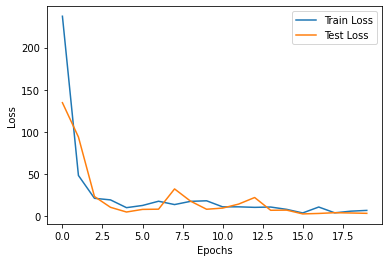

In [72]:
plt.plot(history["loss"][:20],label='Train Loss')
plt.plot(history["val_loss"][:20],label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

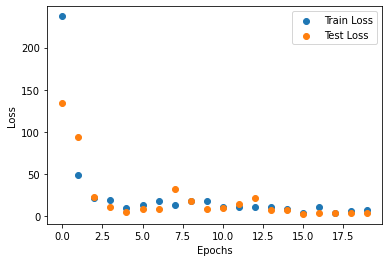

In [73]:
plt.scatter([i for i in range (20)], history["loss"][:20],label='Train Loss')
plt.scatter([i for i in range (20)], history["val_loss"][:20],label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [74]:
cost = MSE(y, l2)

In [75]:
cost.forward()
cost.value

np.float64(0.02423078944241056)